In [874]:
import numpy as np
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import pandas as pd
import math

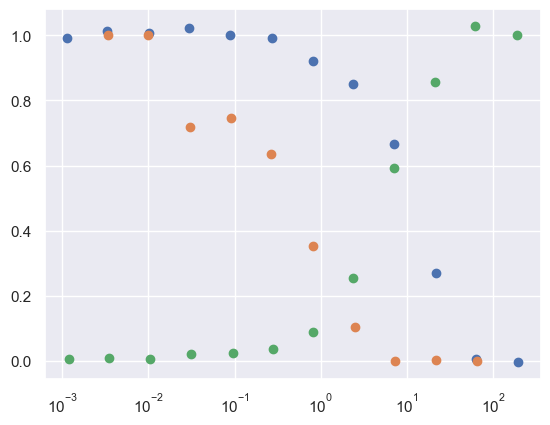

In [875]:
df = pd.read_csv('pd1_10_1_data.csv')
x_data_pd1 = np.asarray(df['xdata'])
y_data = np.asarray(df['ydata'])
y_data_pd1 = y_data/100

df1 = pd.read_csv('ctla4_data_10_1.csv')
x_data_ctla = np.asarray(df1['xdata'])
y_data1 = np.asarray(df1['ydata'])
y_data_ctla = y_data1/100

df2 = pd.read_csv('bispecific_pd1_ctla4_binding_data_10_1.csv')
x_data_ab = np.asarray(df2['xdata'])
y_data2 = np.asarray(df2['ydata'])
y_data_ab = y_data2/100

plt.scatter(x_data_pd1, y_data_pd1)
plt.scatter(x_data_ctla, y_data_ctla)
plt.scatter(x_data_ab, y_data_ab)
plt.xscale('log')

In [876]:
Target_cell_number = 5e3
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [877]:
CTLA_4_D = 10.24e-8 #cm^2s^-1
PD_1_D = 9.5e-8 #cm^2^-1
T_cell_radius = 5e-4 #cm
kon_pd1 = 2.95e5
kon_ctla4 = 6.84e5
"""
k2_CTLA = 4*CTLA_4_D/(math.pi*((r_ab)**2))
k2_PD_1 = 4*PD_1_D/(math.pi*((r_ab)**2))
r_tot_pd1_10_1 = 7.3e5
r_tot_ctla4_10_1 = 5.5e4
r_tot_pd1_40_1 = 1.4e6
r_tot_ctla4_40_1 = 3.9e4
kon_pd1 = 2.95e5
koff_pd1 = 2.36e-4
kon_ctla4 = 6.84e5
koff_ctla4 = 2.88e-4
koff1 = 1e-4
koff2 = 1e-4
"""

'\nk2_CTLA = 4*CTLA_4_D/(math.pi*((r_ab)**2))\nk2_PD_1 = 4*PD_1_D/(math.pi*((r_ab)**2))\nr_tot_pd1_10_1 = 7.3e5\nr_tot_ctla4_10_1 = 5.5e4\nr_tot_pd1_40_1 = 1.4e6\nr_tot_ctla4_40_1 = 3.9e4\nkon_pd1 = 2.95e5\nkoff_pd1 = 2.36e-4\nkon_ctla4 = 6.84e5\nkoff_ctla4 = 2.88e-4\nkoff1 = 1e-4\nkoff2 = 1e-4\n'

In [878]:
def model_S_bispecific(t, z, Ainit, rtot1, rtot2, kon, kon1, k21, k22, koff1, koff2, factor):
    k = Ainit*kon
    k1 = Ainit*kon1
    Atot = factor*1e16*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] - z[2]
    Ag1 = rtot1 - z[0] - z[2]
    Ag2 = rtot2 - z[1] - z[2]

    dA10 = (k*(Ag1)*(A0)/rtot1) - koff1*z[0] - (k22*(Ag2)*z[0]/rtot2) + koff2*z[2]
    dA01 = (k1*(Ag2)*(A0)/rtot2) - koff2*z[1] - (k21*(Ag1)*z[1]/rtot1) + koff1*z[2]
    dA11 = (k22*(Ag2)*z[0]/rtot2) + (k21*(Ag1)*z[1]/rtot1) - (koff1 + koff2)*z[2]

    return [dA10, dA01, dA11]

In [879]:
def myfunc(x, r_tot_pd1_40_1, r_tot_ctla4_40_1, k2_PD_1, k2_CTLA, koff_pd1, koff_ctla4, factor):
    
    ab_vals = np.zeros_like(x)
    ag1_vals = np.zeros_like(x)
    ag2_vals = np.zeros_like(x)
    for i, val in enumerate(x):
        A0 = 1e-9*val

        z = solve_ivp(model_S_bispecific, tspan, z0, method='Radau', t_eval=t, args=(A0, r_tot_pd1_40_1, r_tot_ctla4_40_1, kon_pd1, 
                                                                                 kon_ctla4, k2_PD_1, k2_CTLA, koff_pd1, koff_ctla4, factor))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_STST = A10[-1]
        A01_STST = A01[-1]
        A11_STST = A11[-1]

        Ag1 = (r_tot_pd1_40_1 - A10_STST - A11_STST)/r_tot_pd1_40_1
        Ag2 = (r_tot_ctla4_40_1 - A01_STST - A11_STST)/r_tot_ctla4_40_1
        Ab = 1 - (((r_tot_pd1_40_1 - A10_STST - A11_STST) + (r_tot_ctla4_40_1 - A01_STST - A11_STST))/(r_tot_pd1_40_1 + r_tot_ctla4_40_1))

        ab_vals[i] = Ab
        ag1_vals[i] = Ag1
        ag2_vals[i] = Ag2

    return ag1_vals


In [880]:
popt, pcov = curve_fit(myfunc, x_data_ctla, y_data_ctla, p0= [7.3e5, 5.5e4, 7e5, 7e5, 2.36e-4, 2.88e-4, 50])

In [881]:
print(np.diag(pcov))
print(popt)

[3.23867176e+17 1.64094026e+15 2.00538291e+18 9.83053223e+15
 1.45820540e-03 2.89705645e-03 5.29484066e+09]
[7.24348682e+05 9.09951038e+04 6.86642313e+05 5.77557052e+05
 2.44919448e-04 2.88101947e-04 1.02686192e+02]


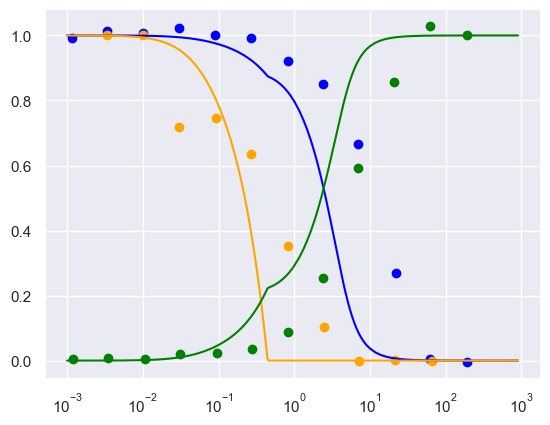

In [882]:
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
A0s = []
vals = np.linspace(1, 9, 50)

for x in A0s1:
    for val in vals:
        A0s.append(x*val)

pd1_vals = np.zeros_like(A0s)
ctla4_vals = np.zeros_like(A0s)
ab_vals = np.zeros_like(A0s)

for i in range(len(A0s)):

    z = solve_ivp(model_S_bispecific, tspan, z0, method='Radau', t_eval=t, args=(A0s[i], popt[0], popt[1], kon_pd1, kon_ctla4, popt[2], popt[3], popt[4], popt[5], popt[6]))
    A10 = z.y[0]
    A01 = z.y[1]
    A11 = z.y[2]
    A10_STST = A10[-1]
    A01_STST = A01[-1]
    A11_STST = A11[-1]

    Ag1 = (popt[0] - A10_STST - A11_STST)/popt[0]
    Ag2 = (popt[1]- A01_STST - A11_STST)/popt[1]
    Ab = 1 - (((popt[0]- A10_STST - A11_STST) + (popt[1] - A01_STST - A11_STST))/(popt[0]+ popt[1]))

    pd1_vals[i] = Ag1
    ctla4_vals[i] = Ag2
    ab_vals[i] = Ab

A0s = np.asarray(A0s)/1e-9
sns.set_theme()
plt.scatter(x_data_pd1, y_data_pd1, color='blue')
plt.scatter(x_data_ctla, y_data_ctla, color='orange')
plt.scatter(x_data_ab, y_data_ab, color='green')
plt.plot(A0s, pd1_vals, color='blue')
plt.plot(A0s, ctla4_vals, color='orange')
plt.plot(A0s, ab_vals, color='green')
plt.xscale('log')
